# **Spatial Transcriptomics Demo**

While single-cell RNA sequencing (scRNA-seq) has revolutionized our ability to classify cell types, it typically requires dissociating tissue, which results in the loss of spatial context.
In complex tissues like the brain or tumor microenvironments, the **location** of a cell is just as important as its identity.

**Spatial Transcriptomics** allows us to profile gene expression while preserving spatial information.
In this case study, we will analyze data from the **10x Genomics Visium** platform.

We will load a dataset from the adult mouse brain (sagittal section).
This is a classic dataset for demonstrating spatial transcriptomics because the brain has highly distinct anatomical regions.

<img src="images/anatomical_planes.jpeg" width="400" />

The data is stored in an `AnnData` object, which holds:
* `.X`: The matrix of counts (genes x spots).
* `.obs`: Annotations for observations (spots), including spatial coordinates.
* `.var`: Annotations for variables (genes).
* `.uns`: Unstructured data, including the histology image.

In [14]:
import squidpy as sq

# Load the dataset.
adata = sq.datasets.visium(sample_id="V1_Adult_Mouse_Brain")

# Ensure gene names are unique.
adata.var_names_make_unique()

print(f"Data shape (genes x spots): {adata.shape}")
print(adata.shape)

print("\nObservation (spots) annotations:")
print(adata.obs.head())  # pyright: ignore[reportAttributeAccessIssue]

print("\nVariable (gene) annotations:")
print(adata.var.head())  # pyright: ignore[reportAttributeAccessIssue]

print("\nSpatial barcodes:")
print(adata.obs_names[:20].tolist())

print("\nGene names:")
print(adata.var_names[:20].tolist())

Data shape (genes x spots): (2702, 32285)
(2702, 32285)

Observation (spots) annotations:
                    in_tissue  array_row  array_col
AAACAAGTATCTCCCA-1          1         50        102
AAACAATCTACTAGCA-1          1          3         43
AAACACCAATAACTGC-1          1         59         19
AAACAGAGCGACTCCT-1          1         14         94
AAACCGGGTAGGTACC-1          1         42         28

Variable (gene) annotations:
                   gene_ids    feature_types genome
Xkr4     ENSMUSG00000051951  Gene Expression   mm10
Gm1992   ENSMUSG00000089699  Gene Expression   mm10
Gm19938  ENSMUSG00000102331  Gene Expression   mm10
Gm37381  ENSMUSG00000102343  Gene Expression   mm10
Rp1      ENSMUSG00000025900  Gene Expression   mm10

Spatial barcodes:
['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1', 'AAACCGGGTAGGTACC-1', 'AAACCGTTCGTCCAGG-1', 'AAACCTCATGAAGTTG-1', 'AAACGAAGAACATACC-1', 'AAACGAGACGGTTGAT-1', 'AAACGGTTGCGAACTG-1', 'AAACTCGGTTCGCAA

/home/vscode/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vscode/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In spatial data, a "spot" captures RNA from a specific location.
Some spots may cover areas with little tissue or artifacts.
We calculate QC metrics and visualized the following two metrics for all spots:

- `total_counts`: Represents the total number of RNA molecules (UMI counts) detected in each spot.
- `n_genes_by_counts`: Represents the number of unique genes detected in each spot.

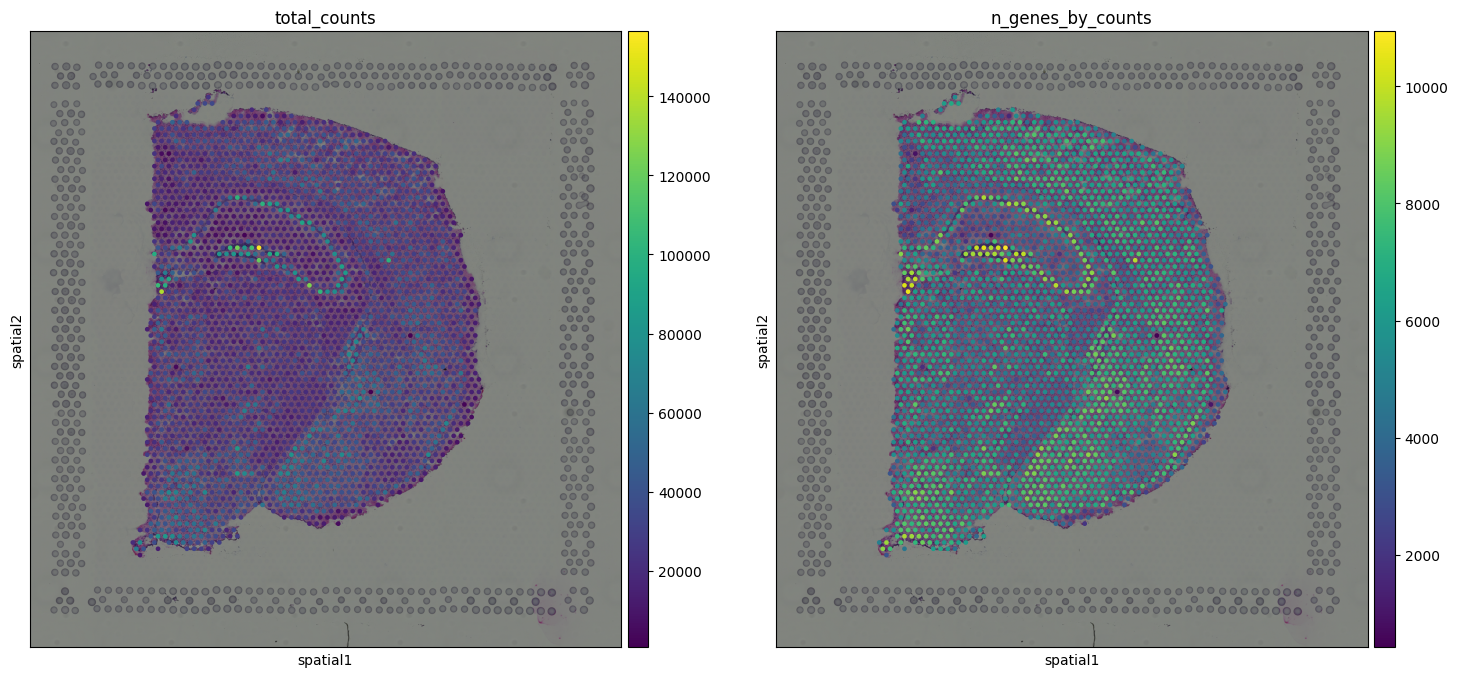

In [15]:
import matplotlib.pyplot as plt
import scanpy as sc

sc.pp.calculate_qc_metrics(adata, inplace=True)
plt.rcParams["figure.figsize"] = (8, 8)
sq.pl.spatial_scatter(adata, color=["total_counts", "n_genes_by_counts"])  # pyright: ignore[reportCallIssue]

Raw count data is not suitable for direct comparison because of technical variations in sequencing depth.
Hence, we perform three preprocessing steps:

1. **Normalization:** Scales counts so that every spot has the same "total" count potential.
2. **Log-transformation:** Stabilizes variance.
3. **Feature Selection:** Identifies highly variable genes to filter out uninformative genes and focus on those with strong biological signals.

The log-transformation is typically applied as: $x' = \log(x + 1)$.

Key reasons for the log-transformation:
- Reducing skewness: Gene expression data often follows a highly skewed distribution, with a few genes having very high expression levels and many genes having low expression levels. Log-transformation compresses the high values while spreading out the low values, making the data more symmetric and easier to analyze.
- Stabilizing variance: In raw count data, the variance tends to increase with the mean (heteroscedasticity). For example, genes with higher expression levels often have higher variability. Log-transformation reduces this dependency between the mean and variance, making the data more homoscedastic (constant variance), which is a key assumption for many statistical methods.

In [16]:
import numpy as np

# Normalization.
sc.pp.normalize_total(adata, inplace=True)

# Log-transformation.
sc.pp.log1p(adata)

# Identify highly variable genes.
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=500)
adata = adata[:, adata.var["highly_variable"]]

Before automatically clustering the data, we will look for specific cell types first, by creating spatial plots for **Gad1** (a marker for inhibitory neurons) and **Aqp4** (a marker for astrocytes).

Inhibitory neurons are a type of neuron in the brain that reduce or suppress the activity of other neurons.

Astrocytes are a type of glial cell (non-neuronal cells in the central and peripheral nervous systems that provide critical support and protection for neurons) in the brain and central nervous system.
They provide structural and metabolic support to neurons.

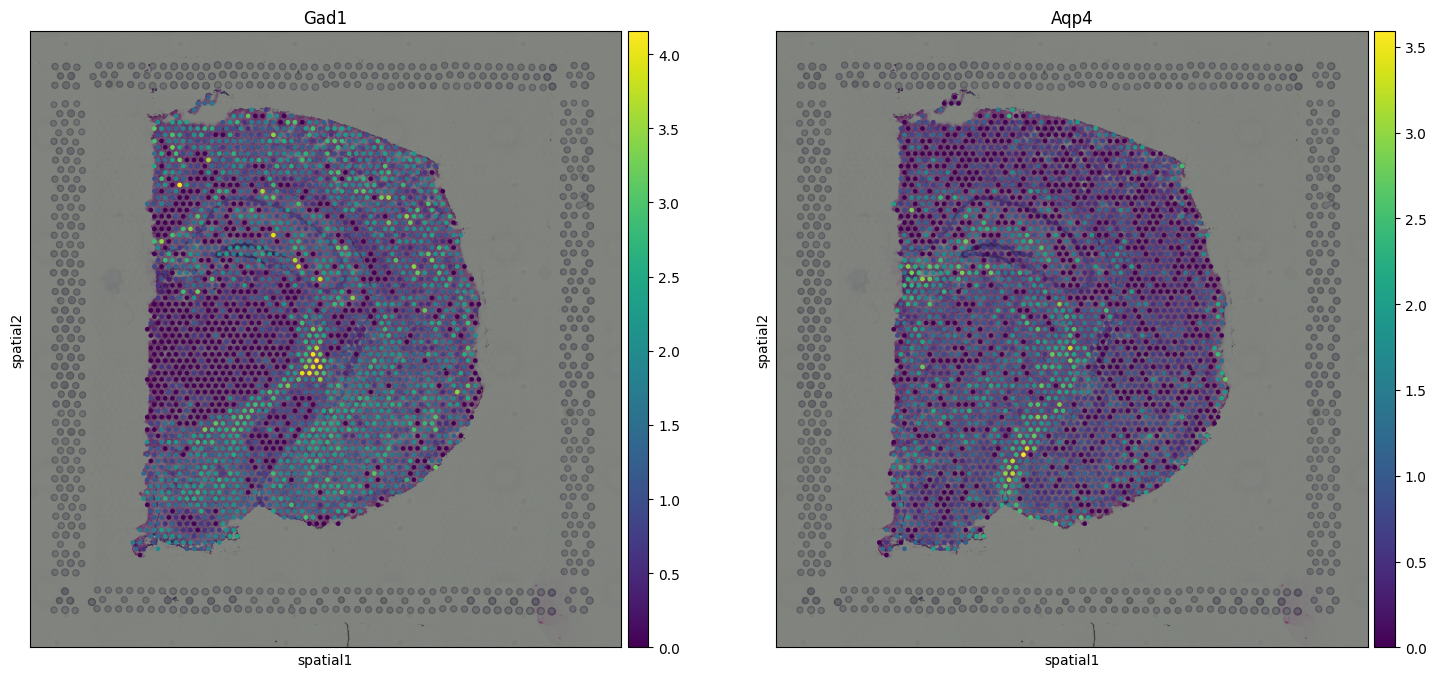

In [17]:
sq.pl.spatial_scatter(adata, color=["Gad1", "Aqp4"])  # pyright: ignore[reportCallIssue]

To find "tissue comains" (i.e., regions of the tissue with similar molecular profiles), we perform dimensionality reduction followed by [Leiden clustering](https://doi.org/10.1038/s41598-019-41695-z).

Leiden clustering is an algorithm used to identify communities or clusters in a graph.
It optimizes modularity or a similar quality function to partition the graph into groups of nodes that are more densely connected to each other than to nodes in other groups.
In the context of single-cell or spatial transcriptomics, it is used to group cells or spots with similar gene expression profiles.

In [18]:
# Reduce the dimensionality of the data.
sc.pp.pca(adata, n_comps=50)

# Construct a k-nearest neighbors graph based on the PCA-reduced data.
sc.pp.neighbors(adata)

# Perform clustering on this graph to identify biologically meaningful tissue domains.
sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.8,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

/home/vscode/.local/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


We can now visualize the clusters.

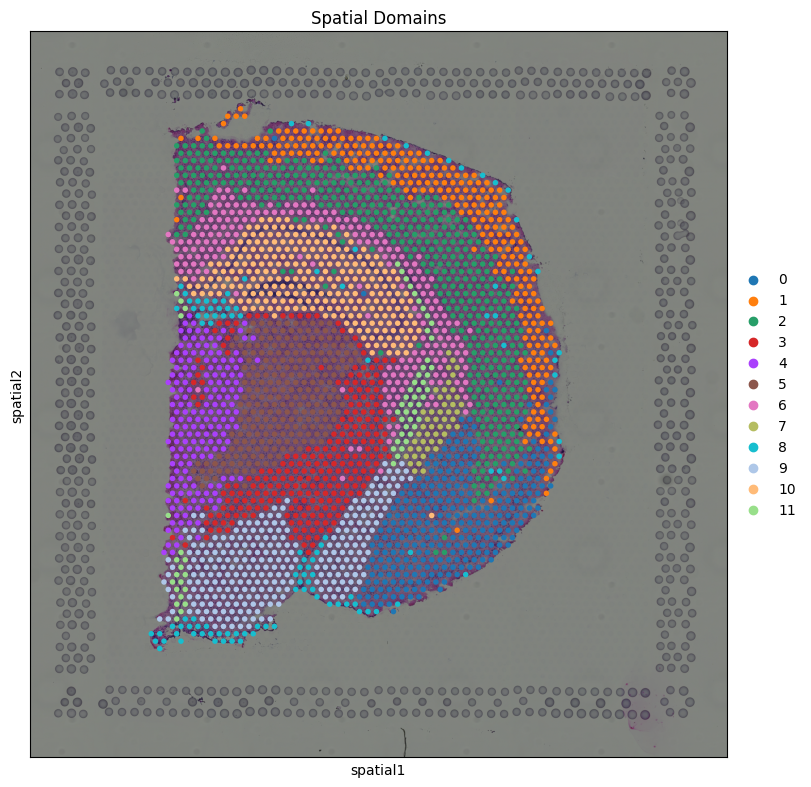

In [19]:
sq.pl.spatial_scatter(adata, color="clusters", title="Spatial Domains")  # pyright: ignore[reportCallIssue]

The clustering reveals main brain structures:

- The layers on the top and outer edge (domains 6, 2, and 1) represent the different layers of the isocortex.
- The distinct "swirl" or "C-shape" in the middle-left (domains 3 and 5) identifies the hippocampus.